In [1]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import ParticleDimer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, create_RealNVPNet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.sampling.latent_sampling import BiasedModel
from deep_boltzmann.sampling.permutation import HungarianMapper
from deep_boltzmann.util import load_obj, save_obj

In [6]:
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

In [7]:
# reweighting
def test_sample_rew(network, rcfunc, rcmin, rcmax, temperature=1.0, nsample=100000):
    sample_z, sample_x, energy_z, energy_x, log_w = network.sample(temperature=1.0, nsample=nsample)
    bin_means, Es = free_energy_bootstrap(rcfunc(sample_x), rcmin, rcmax, 100, sample=100, weights=np.exp(log_w))
    fig = plt.figure(figsize=(5, 4))
    # model.plot_dimer_energy()
    plt.ylim(-10, 20)
    Emean = mean_finite(Es, axis=0)-7
    Estd = std_finite(Es, axis=0)
    plt.errorbar(bin_means, Emean, 2*Estd)
    # variance
    var = mean_finite(std_finite(Es, axis=0) ** 2)
    print('Estimator Standard Error: ', np.sqrt(var))
    return fig, bin_means, Emean, Estd

In [8]:
def latent_interpolation(bg, x1, x2, nstep=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        zpath1 = z1 * (1-lambdas[::2])
        zpath2 = z2 * (lambdas[::2]) 
        zpath = np.vstack([zpath1, zpath2])
    else:
        zpath = z1 + lambdas*(z2-z1)
    xpath = bg.transform_zx(zpath)
    return xpath

In [9]:
def low_energy_fraction(energies, Emax):
    low_energy_count = [np.count_nonzero(E<Emax) for E in energies]
    sizes = [E.size for E in energies]
    low_energy_fraction = np.array(low_energy_count) / sizes
    return low_energy_fraction

In [10]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [11]:
paper_dir = '/Users/noe/data/papers/NoeEtAl_BoltzmannGeneratorsRev/'

Particle model
---

In [12]:
# load trajectory data
trajdict = np.load('../data/particles_tilted/trajdata_long.npz')
import ast
params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [13]:
# create model
params['grid_k'] = 0.0
model = ParticleDimer(params=params)

Text(0,0.5,'Energy / $kT_0$')

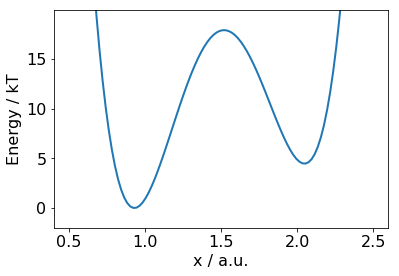

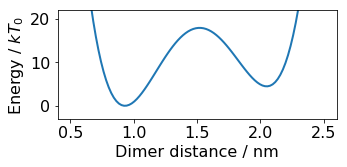

In [14]:
xx, xE = model.plot_dimer_energy();
plt.figure(figsize=(5, 2))
plt.plot(xx, xE, linewidth=2)
plt.ylim(-3, 22)
plt.xlabel('Dimer distance / nm')
plt.ylabel('Energy / $kT_0$')
#plt.savefig(paper_dir + 'figs/particles/particle_dimer_potential.pdf', bbox_inches='tight')

In [15]:
W = np.exp(-xE)
-np.log(np.sum(W[xx < 1.5]) / np.sum(W[xx >= 1.5]))

-4.4139043664615345

In [16]:
# hyperparameters
hyperparams = {'layer_types' : 'RRRRRRRR',
               'nl_layers' : 3,
               'nl_hidden' : 200,
               'nl_activation' : 'tanh',
               'zstd' : 1.0,
               'reg_Jxz' : 0.0,
               'temperature' : [0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4.0],
               'weight_ML' : 0.1,
               'weight_W2' : 0.0,
               'weight_RC' : 10.0,
               }

Umbrella sampling reference
-------

In [17]:
from deep_boltzmann.sampling.umbrella_sampling import UmbrellaSampling
from deep_boltzmann.sampling.metropolis import MetropolisGauss

In [17]:
## Either run Umbrella Sampling here....
#sampler = MetropolisGauss(model, model.init_positions(1.0), noise=0.02, stride=10)
#sampler.run(nsteps=10000)
#us = UmbrellaSampling(model, sampler, model.dimer_distance, sampler.traj[-1], 30, 250, 0.7, 2.3, forward_backward=True)
#us.run(nsteps=20000, verbose=True)

0.15 -60.78149494219376
0.15 -54.80906030006441
0.15 -66.82129157380976
0.25 -34.02408228190505
0.25 -36.378770183999876
0.25 -31.033689809728696
0.5 -14.286441470542922
0.5 -15.261248313620838
0.5 -13.63487889725406
1.0 -6.628717637498096
1.0 -7.124522164227016
1.0 -7.547679576558392
2.0 -3.3690130502955613
2.0 -3.298268077804168
2.0 -3.0709626368335443


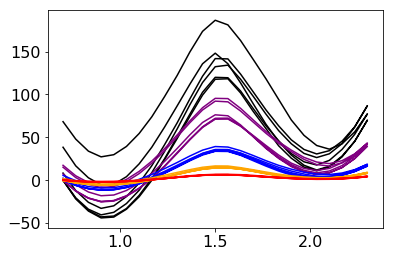

In [18]:
## ... or load saved Umbrella Sampling data.
npzfile = np.load(paper_dir + 'figs/particles/US_data.npz')
colors = ['black', 'purple', 'blue', 'orange', 'red']
x = npzfile['umbrella_positions']
temperatures_US = npzfile['temperatures']
dF_closed_open_US = []
for i, dF in enumerate(npzfile['umbrella_free_energies']):
    icolor = i // 3
    plt.plot(x, dF, color=colors[icolor])
    W = np.exp(-dF)
    dF_at_kT0 = -np.log(np.sum(W[x < 1.5]) / np.sum(W[x >= 1.5]))
    dF_closed_open_US.append(dF_at_kT0)
    print(temperatures_US[i], dF_at_kT0)    

In [19]:
# Estimate free energy profile and errors at kT=1 
umbrella_positions = npzfile['umbrella_positions']
# split in two halves because we ran forward and backward
umbrella_positions = umbrella_positions[:umbrella_positions.size//2]
umbrella_free_energies = [npzfile['umbrella_free_energies'][i][:umbrella_positions.size] for i in range(9, 12)] \
                       + [npzfile['umbrella_free_energies'][i][umbrella_positions.size:][::-1] for i in range(9, 12)] 
# align values
umbrella_free_energies = [F-F.mean() for F in umbrella_free_energies]

Boltzmann Generator
-------

In [20]:
batchsize_ML =  500
batchsize_KL = 1000
noise_intensity = 0.0

In [21]:
X0 = np.vstack([traj_closed_train, traj_open_train])

In [22]:
Nnoise = xval.shape[0]
X0noise = X0[np.random.choice(X0.shape[0], Nnoise)] + noise_intensity * np.random.randn(Nnoise, X0.shape[1])
X0noise = X0noise.astype(np.float32)

In [23]:
#X0 = np.vstack([traj_closed_train[::100], traj_open_train[::100]])

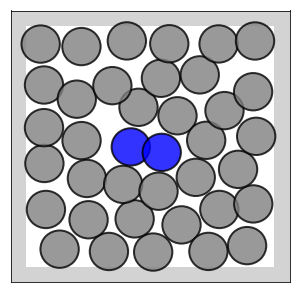

In [24]:
model.draw_config(X0noise[1001], dimercolor='blue', alpha=0.8);

In [25]:
bg = invnet(model.dim, 'RRRRRRRR', energy_model=model, nl_layers=4, nl_hidden=200, #100
            nl_activation='relu', nl_activation_scale='tanh', whiten=X0noise)

W<RRRRRRRR>
W 76 0 0
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0
Instructions for updating:
Colocations handled automatically by placer.


In [26]:
hist_bg_ML = bg.train_ML(X0noise, xval=xval, epochs=200, lr=0.001, batch_size=batchsize_ML, 
                         std=1.0, verbose=0, return_test_energies=True)

Instructions for updating:
Use tf.cast instead.


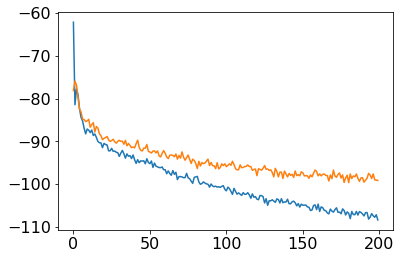

In [27]:
plt.plot(hist_bg_ML[0])
plt.plot(hist_bg_ML[1])
#plt.ylim(0, 100)

(0, 3)

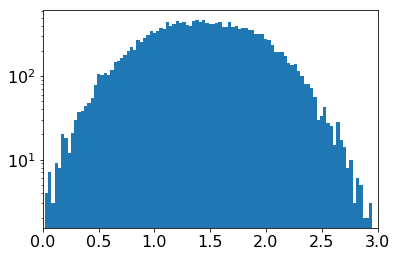

In [28]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

Regular training
-----

In [29]:
temperature=1.0

In [30]:
# initial training
Eschedule = [[200,  0.00001, 1e6, 1e3,  0.0, 10.0],
             [100,  0.0001, 1e6,  300,  0.0, 10.0],
             [100,  0.0001, 1e5,  100,  0.0, 10.0],
             [100,  0.0001, 5e4,   50,  0.0, 10.0],
             [100,  0.0001, 5e4,   20,  0.0, 10.0],
             [200,  0.0001, 5e4,    5,  0.0, 10.0]]

In [31]:
hists_bg_KL = []
for i, s in enumerate(Eschedule):
    print(s)#'high_energy =', s[0], 'weight_ML =', s[1], 'epochs =', s[2])
    sys.stdout.flush()
    hist_bg_KL = bg.train_flexible(X0noise, xval=xval, epochs=s[0], lr=s[1], batch_size=batchsize_KL,
                                   verbose=1, high_energy=s[2], max_energy=1e10,
                                   weight_ML=s[3], weight_KL=1.0, temperature=temperature, weight_MC=0.0, weight_W2=s[4],
                                   weight_RCEnt=s[5], rc_func=model.dimer_distance_tf, rc_min=0.5, rc_max=2.5,
                                   std=1.0, reg_Jxz=0.0, return_test_energies=True)
    hists_bg_KL.append(hist_bg_KL)

[200, 1e-05, 1000000.0, 1000.0, 0.0, 10.0]


/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'index_layer_3/GatherV2:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'lambda_51/add:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'lambda_51/add:0' shape=(?, 76) dtype=float32>]
  ' Found: ' + str(self.outputs))


Epoch 0/200 loss -36450.4297 -28106.1660 index_layer_3_loss -107.1694 -98.1329 lambda_51_loss 70440.5781 69746.7500 lambda_51_loss 27.8357 28.0022 
Epoch 1/200 loss -39960.9844 -20927.0527 index_layer_3_loss -108.0520 -98.3035 lambda_51_loss 67811.8516 77095.8438 lambda_51_loss 27.9212 28.0650 
Epoch 2/200 loss -39233.6641 -30869.5312 index_layer_3_loss -108.1136 -99.0427 lambda_51_loss 68601.1875 67894.8516 lambda_51_loss 27.8766 27.8313 
Epoch 3/200 loss -40518.1641 -22544.0957 index_layer_3_loss -107.7978 -99.1124 lambda_51_loss 67002.8516 76286.6719 lambda_51_loss 27.6806 28.1685 
Epoch 4/200 loss -32927.8867 -26910.7363 index_layer_3_loss -107.8916 -98.5566 lambda_51_loss 74686.7031 71367.6562 lambda_51_loss 27.7026 27.8240 
Epoch 5/200 loss -29943.6641 -19487.3340 index_layer_3_loss -107.4344 -98.6707 lambda_51_loss 77211.0547 78904.1562 lambda_51_loss 27.9656 27.9174 
Epoch 6/200 loss -41201.6719 -29391.2266 index_layer_3_loss -107.6781 -99.1290 lambda_51_loss 66196.2812 69457.8

Epoch 56/200 loss -73204.0859 -57000.6797 index_layer_3_loss -107.2056 -98.0717 lambda_51_loss 33719.7344 40788.9766 lambda_51_loss 28.1804 28.1999 
Epoch 57/200 loss -63801.1836 -52316.0508 index_layer_3_loss -107.6235 -98.3249 lambda_51_loss 43541.6953 45728.5039 lambda_51_loss 28.0661 28.0306 
Epoch 58/200 loss -66097.8906 -61992.4180 index_layer_3_loss -107.0059 -98.0395 lambda_51_loss 40626.0547 35764.4258 lambda_51_loss 28.1916 28.2627 
Epoch 59/200 loss -68506.6406 -64118.4844 index_layer_3_loss -106.7041 -97.7345 lambda_51_loss 37917.0547 33334.4922 lambda_51_loss 28.0402 28.1523 
Epoch 60/200 loss -75095.1875 -60612.9375 index_layer_3_loss -107.6175 -97.3711 lambda_51_loss 32243.9727 36478.6484 lambda_51_loss 27.8310 27.9490 
Epoch 61/200 loss -75472.2188 -61400.8281 index_layer_3_loss -107.3942 -98.0181 lambda_51_loss 31642.2930 36332.7617 lambda_51_loss 27.9641 28.4473 
Epoch 62/200 loss -70928.3281 -55574.8555 index_layer_3_loss -107.0836 -97.5465 lambda_51_loss 35874.5938 

Epoch 111/200 loss -86931.9688 -69487.2969 index_layer_3_loss -106.7543 -96.6022 lambda_51_loss 19540.6289 26831.3887 lambda_51_loss 28.1690 28.3540 
Epoch 112/200 loss -84907.6094 -70752.8281 index_layer_3_loss -106.2293 -96.2156 lambda_51_loss 21036.6406 25177.9355 lambda_51_loss 28.5032 28.4867 
Epoch 113/200 loss -86474.9844 -75664.7188 index_layer_3_loss -106.6813 -95.8815 lambda_51_loss 19920.8965 19932.1836 lambda_51_loss 28.5461 28.4597 
Epoch 114/200 loss -80677.5156 -73385.6797 index_layer_3_loss -106.7536 -96.1549 lambda_51_loss 25794.8086 22489.3574 lambda_51_loss 28.1277 27.9885 
Epoch 115/200 loss -83508.9844 -70821.8359 index_layer_3_loss -106.4680 -97.1679 lambda_51_loss 22673.2637 26064.3672 lambda_51_loss 28.5715 28.1699 
Epoch 116/200 loss -86136.7188 -67468.7344 index_layer_3_loss -106.5289 -96.9245 lambda_51_loss 20108.8887 29169.5312 lambda_51_loss 28.3294 28.6189 
Epoch 117/200 loss -85363.6328 -79332.1875 index_layer_3_loss -106.7826 -95.8440 lambda_51_loss 2113

Epoch 166/200 loss -91105.6719 -81648.2812 index_layer_3_loss -106.4348 -95.6051 lambda_51_loss 15046.0254 13672.7236 lambda_51_loss 28.3150 28.4067 
Epoch 167/200 loss -88363.3047 -81219.3672 index_layer_3_loss -105.4599 -96.8810 lambda_51_loss 16813.6230 15375.2275 lambda_51_loss 28.2996 28.6446 
Epoch 168/200 loss -92342.1641 -75326.0859 index_layer_3_loss -105.9302 -95.6011 lambda_51_loss 13302.9824 19992.7168 lambda_51_loss 28.5074 28.2305 
Epoch 169/200 loss -84006.7031 -82787.3281 index_layer_3_loss -106.1423 -96.1292 lambda_51_loss 21850.5508 13056.9141 lambda_51_loss 28.5044 28.4973 
Epoch 170/200 loss -85802.0859 -78758.4453 index_layer_3_loss -105.5128 -96.6730 lambda_51_loss 19422.0996 17626.9883 lambda_51_loss 28.8583 28.7554 
Epoch 171/200 loss -87933.4141 -79675.1562 index_layer_3_loss -105.6192 -96.3292 lambda_51_loss 17398.2578 16367.3711 lambda_51_loss 28.7563 28.6706 
Epoch 172/200 loss -85234.0000 -79628.1328 index_layer_3_loss -105.7282 -96.6600 lambda_51_loss 2020

Epoch 21/100 loss -27563.2344 -24106.8359 index_layer_3_loss -99.2834 -88.0691 lambda_51_loss 1900.9045 1987.5201 lambda_51_loss 32.0896 32.6387 
Epoch 22/100 loss -27290.9180 -23263.6836 index_layer_3_loss -98.3969 -87.6360 lambda_51_loss 1902.2310 2698.8069 lambda_51_loss 32.5928 32.8306 
Epoch 23/100 loss -28541.5684 -24167.1973 index_layer_3_loss -99.5195 -87.3795 lambda_51_loss 979.8705 1717.6379 lambda_51_loss 33.4407 32.9021 
Epoch 24/100 loss -27864.6641 -25421.4727 index_layer_3_loss -99.1652 -87.8309 lambda_51_loss 1562.0280 600.5500 lambda_51_loss 32.2856 32.7261 
Epoch 25/100 loss -28209.1621 -23279.8184 index_layer_3_loss -99.5930 -87.4358 lambda_51_loss 1341.8613 2628.0066 lambda_51_loss 32.6876 32.2903 
Epoch 26/100 loss -28803.4961 -25511.2285 index_layer_3_loss -99.2896 -87.8056 lambda_51_loss 653.8470 499.9951 lambda_51_loss 32.9546 33.0462 
Epoch 27/100 loss -28014.0586 -24018.5059 index_layer_3_loss -99.4431 -88.4035 lambda_51_loss 1496.4036 2180.7520 lambda_51_loss

Epoch 78/100 loss -29803.4082 -24522.8711 index_layer_3_loss -102.2206 -91.6435 lambda_51_loss 545.8595 2652.2317 lambda_51_loss 31.6902 31.7961 
Epoch 79/100 loss -28693.5156 -26830.9102 index_layer_3_loss -101.7038 -92.1159 lambda_51_loss 1496.4473 492.2555 lambda_51_loss 32.1162 31.1614 
Epoch 80/100 loss -30068.2773 -26495.9180 index_layer_3_loss -102.7252 -91.4449 lambda_51_loss 436.7730 623.0424 lambda_51_loss 31.2505 31.4499 
Epoch 81/100 loss -29704.3281 -26349.4355 index_layer_3_loss -101.9483 -91.0912 lambda_51_loss 561.0055 667.5111 lambda_51_loss 31.9168 31.0418 
Epoch 82/100 loss -28297.5645 -24570.5059 index_layer_3_loss -101.5592 -91.2639 lambda_51_loss 1855.3618 2496.3105 lambda_51_loss 31.4841 31.2366 
Epoch 83/100 loss -29763.1289 -26563.0566 index_layer_3_loss -102.1114 -90.9826 lambda_51_loss 555.4881 414.5096 lambda_51_loss 31.4809 31.7227 
Epoch 84/100 loss -29558.4199 -25400.7578 index_layer_3_loss -102.2217 -92.1395 lambda_51_loss 790.7562 1938.0422 lambda_51_lo

Epoch 35/100 loss -9412.4404 -8562.2227 index_layer_3_loss -102.9621 -92.6658 lambda_51_loss 588.1917 401.5429 lambda_51_loss 29.5581 30.2818 
Epoch 36/100 loss -9405.1260 -8437.0410 index_layer_3_loss -102.7778 -92.3471 lambda_51_loss 576.4690 497.3827 lambda_51_loss 29.6187 30.0284 
Epoch 37/100 loss -9647.2021 -8461.9551 index_layer_3_loss -103.3740 -93.1637 lambda_51_loss 394.3500 555.8629 lambda_51_loss 29.5853 29.8555 
Epoch 38/100 loss -9620.9189 -8532.4961 index_layer_3_loss -103.3082 -93.1082 lambda_51_loss 407.0722 474.3736 lambda_51_loss 30.2829 30.3950 
Epoch 39/100 loss -9426.3037 -8423.6172 index_layer_3_loss -103.3557 -92.4752 lambda_51_loss 610.9653 519.2856 lambda_51_loss 29.8301 30.4611 
Epoch 40/100 loss -9511.6934 -8548.9102 index_layer_3_loss -103.0013 -93.1621 lambda_51_loss 486.9473 462.5212 lambda_51_loss 30.1494 30.4778 
Epoch 41/100 loss -9436.9189 -8344.1133 index_layer_3_loss -102.9498 -92.5423 lambda_51_loss 560.4297 609.4610 lambda_51_loss 29.7629 30.0652 

Epoch 93/100 loss -9677.6494 -8642.0576 index_layer_3_loss -103.3323 -93.2515 lambda_51_loss 368.7336 397.2011 lambda_51_loss 28.6851 28.5889 
Epoch 94/100 loss -9652.4531 -8559.4854 index_layer_3_loss -104.2059 -92.6648 lambda_51_loss 478.0016 422.1913 lambda_51_loss 29.0136 28.4800 
Epoch 95/100 loss -9334.0811 -8694.2422 index_layer_3_loss -103.7288 -94.0496 lambda_51_loss 749.4830 422.3393 lambda_51_loss 28.9318 28.8381 
Epoch 96/100 loss -9505.9434 -8482.0938 index_layer_3_loss -104.0402 -92.7058 lambda_51_loss 612.6578 500.9039 lambda_51_loss 28.5422 28.7585 
Epoch 97/100 loss -9762.0664 -8533.2285 index_layer_3_loss -104.1798 -93.6674 lambda_51_loss 368.5256 551.9799 lambda_51_loss 28.7388 28.1528 
Epoch 98/100 loss -9665.9785 -8512.8564 index_layer_3_loss -104.5995 -93.4064 lambda_51_loss 510.5596 545.0948 lambda_51_loss 28.3413 28.2687 
Epoch 99/100 loss -9669.4395 -8556.4395 index_layer_3_loss -103.8489 -93.2004 lambda_51_loss 426.1902 482.2596 lambda_51_loss 28.9263 28.1345 

Epoch 51/100 loss -4469.0996 -3937.2527 index_layer_3_loss -103.5664 -92.3749 lambda_51_loss 432.6733 403.7685 lambda_51_loss 27.6545 27.7726 
Epoch 52/100 loss -4607.6689 -3976.3557 index_layer_3_loss -104.4589 -93.0342 lambda_51_loss 337.4148 400.2011 lambda_51_loss 27.7860 27.5152 
Epoch 53/100 loss -4508.3057 -3998.5876 index_layer_3_loss -103.8531 -93.4739 lambda_51_loss 408.8380 402.1212 lambda_51_loss 27.5510 27.2985 
Epoch 54/100 loss -4504.0732 -4054.2317 index_layer_3_loss -104.0720 -93.5647 lambda_51_loss 422.7497 346.8059 lambda_51_loss 27.6776 27.7197 
Epoch 55/100 loss -4514.7363 -4030.0579 index_layer_3_loss -103.7152 -92.9057 lambda_51_loss 396.9114 338.8741 lambda_51_loss 27.4112 27.6352 
Epoch 56/100 loss -4502.6187 -4083.5962 index_layer_3_loss -103.9851 -94.0430 lambda_51_loss 421.2563 338.6436 lambda_51_loss 27.5381 27.9910 
Epoch 57/100 loss -4517.4517 -4030.6765 index_layer_3_loss -104.1298 -93.2468 lambda_51_loss 412.0359 353.8420 lambda_51_loss 27.7002 27.7821 

Epoch 9/100 loss -1480.9205 -1270.4229 index_layer_3_loss -103.5055 -92.8251 lambda_51_loss 317.3220 309.6832 lambda_51_loss 27.1868 27.6396 
Epoch 10/100 loss -1419.8987 -1217.6409 index_layer_3_loss -103.8880 -92.4692 lambda_51_loss 383.8452 356.1165 lambda_51_loss 27.4016 27.5627 
Epoch 11/100 loss -1470.9695 -1205.2871 index_layer_3_loss -102.8651 -92.1454 lambda_51_loss 311.5969 359.1366 lambda_51_loss 27.4736 27.8484 
Epoch 12/100 loss -1428.9653 -1256.2356 index_layer_3_loss -103.0603 -92.5968 lambda_51_loss 357.0397 318.3036 lambda_51_loss 27.5200 27.7397 
Epoch 13/100 loss -1473.7151 -1255.2266 index_layer_3_loss -102.9447 -92.4820 lambda_51_loss 309.0245 318.7448 lambda_51_loss 27.6154 27.5670 
Epoch 14/100 loss -1477.8376 -1247.4302 index_layer_3_loss -103.2156 -91.5259 lambda_51_loss 310.4091 308.3322 lambda_51_loss 27.6065 27.4756 
Epoch 15/100 loss -1477.0367 -1263.2998 index_layer_3_loss -102.8315 -92.2754 lambda_51_loss 303.7087 305.8463 lambda_51_loss 27.5884 27.6362 


Epoch 67/100 loss -1412.5403 -1270.6292 index_layer_3_loss -103.3364 -92.7009 lambda_51_loss 382.0395 309.5406 lambda_51_loss 27.2148 27.3848 
Epoch 68/100 loss -1488.0032 -1196.4126 index_layer_3_loss -103.0936 -91.4506 lambda_51_loss 301.0376 360.3369 lambda_51_loss 27.2832 27.2263 
Epoch 69/100 loss -1479.2798 -1247.1760 index_layer_3_loss -103.0911 -91.7194 lambda_51_loss 310.0767 314.6848 lambda_51_loss 27.2465 27.2527 
Epoch 70/100 loss -1440.5027 -1229.3676 index_layer_3_loss -102.8171 -92.5685 lambda_51_loss 342.9614 349.1499 lambda_51_loss 27.2878 27.2853 
Epoch 71/100 loss -1428.2863 -1189.8982 index_layer_3_loss -102.7618 -92.5619 lambda_51_loss 354.9101 387.2452 lambda_51_loss 27.2040 27.4094 
Epoch 72/100 loss -1455.0520 -1210.6626 index_layer_3_loss -103.0491 -92.2409 lambda_51_loss 334.2436 361.6643 lambda_51_loss 27.1686 27.2490 
Epoch 73/100 loss -1428.6205 -1279.6663 index_layer_3_loss -102.9711 -92.8202 lambda_51_loss 359.1819 305.9957 lambda_51_loss 27.1619 27.0742 

Epoch 25/200 loss 65.1079 106.7624 index_layer_3_loss -100.0576 -90.2772 lambda_51_loss 294.6692 289.5160 lambda_51_loss 27.0727 26.8632 
Epoch 26/200 loss 113.9348 106.4134 index_layer_3_loss -99.5527 -90.8596 lambda_51_loss 341.1629 291.5172 lambda_51_loss 27.0535 26.9194 
Epoch 27/200 loss 56.8293 113.5356 index_layer_3_loss -100.6610 -89.2357 lambda_51_loss 290.2538 290.8127 lambda_51_loss 26.9881 26.8901 
Epoch 28/200 loss 59.0260 114.1139 index_layer_3_loss -99.9684 -89.6906 lambda_51_loss 288.3289 291.3195 lambda_51_loss 27.0539 27.1247 
Epoch 29/200 loss 60.0458 107.6114 index_layer_3_loss -100.2330 -90.2110 lambda_51_loss 291.5891 289.4476 lambda_51_loss 26.9622 26.9219 
Epoch 30/200 loss 58.9336 105.9735 index_layer_3_loss -100.3212 -90.6777 lambda_51_loss 291.0207 290.1947 lambda_51_loss 26.9519 26.9167 
Epoch 31/200 loss 64.3355 112.9763 index_layer_3_loss -100.0691 -89.2352 lambda_51_loss 295.5479 291.4474 lambda_51_loss 26.9133 26.7705 
Epoch 32/200 loss 58.4083 113.0402 

Epoch 85/200 loss 64.0280 105.5872 index_layer_3_loss -100.7354 -90.6189 lambda_51_loss 300.5200 289.9320 lambda_51_loss 26.7185 26.8749 
Epoch 86/200 loss 49.6338 112.5040 index_layer_3_loss -101.1608 -90.2920 lambda_51_loss 287.3891 295.3748 lambda_51_loss 26.8049 26.8589 
Epoch 87/200 loss 51.2019 104.9137 index_layer_3_loss -101.3698 -90.3648 lambda_51_loss 290.2581 288.6875 lambda_51_loss 26.7793 26.8050 
Epoch 88/200 loss 62.6539 104.9208 index_layer_3_loss -99.9736 -90.1505 lambda_51_loss 294.2904 288.2075 lambda_51_loss 26.8232 26.7466 
Epoch 89/200 loss 51.0353 109.6580 index_layer_3_loss -101.4813 -90.3957 lambda_51_loss 290.5025 294.0379 lambda_51_loss 26.7940 26.7598 
Epoch 90/200 loss 54.4612 109.4290 index_layer_3_loss -100.6755 -89.5183 lambda_51_loss 290.5609 289.5401 lambda_51_loss 26.7278 26.7480 
Epoch 91/200 loss 58.0779 120.6066 index_layer_3_loss -100.5746 -90.7012 lambda_51_loss 292.8944 305.9948 lambda_51_loss 26.8057 26.8118 
Epoch 92/200 loss 56.6935 107.5224 

Epoch 145/200 loss 61.1261 110.6222 index_layer_3_loss -98.7678 -88.9758 lambda_51_loss 283.5586 283.6966 lambda_51_loss 27.1406 27.1805 
Epoch 146/200 loss 72.6400 113.5310 index_layer_3_loss -99.7338 -88.3185 lambda_51_loss 300.7820 285.2130 lambda_51_loss 27.0527 26.9910 
Epoch 147/200 loss 60.5021 110.5999 index_layer_3_loss -98.9180 -88.9717 lambda_51_loss 283.7272 284.2597 lambda_51_loss 27.1365 27.1199 
Epoch 148/200 loss 80.7827 119.8735 index_layer_3_loss -99.0867 -86.9697 lambda_51_loss 307.5666 284.7314 lambda_51_loss 26.8650 26.9991 
Epoch 149/200 loss 58.7762 113.5626 index_layer_3_loss -99.1360 -88.3495 lambda_51_loss 285.3354 285.7374 lambda_51_loss 26.9121 26.9573 
Epoch 150/200 loss 63.4449 115.5454 index_layer_3_loss -98.4096 -87.9190 lambda_51_loss 286.4182 284.7429 lambda_51_loss 26.9075 27.0397 
Epoch 151/200 loss 64.8636 117.0561 index_layer_3_loss -98.1616 -87.5372 lambda_51_loss 286.0058 287.0364 lambda_51_loss 26.9666 26.7706 
Epoch 152/200 loss 61.1437 118.489

In [32]:
xeners = []
zeners = []
for h in hists_bg_KL:
    xeners += h[3]
    zeners += h[4]
hist_bg_KL_combined = [hists_bg_KL[0][0], 
                       np.vstack([h[1] for h in hists_bg_KL]),
                       np.vstack([h[2] for h in hists_bg_KL]),
                       xeners, zeners]

In [33]:
def plot_convergence(hist_ML, hist_KL, enerx_cut, enerz_cut, MLcol=1, KLcol=2):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 10))
    niter1 = len(hist_ML[0])
    niter2 = hist_KL[1].shape[0]
    niter = niter1 + niter2
    # ML loss
    losses_ML = np.concatenate([hist_ML[0], hist_KL[1][:, MLcol]])
    xticks = np.arange(niter1 + niter2) + 1
    axes[0].plot(xticks, losses_ML, color='black')
    axes[0].set_xlim(0, niter + 1)
    axes[0].set_ylabel('ML loss')
    axes[0].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # KL loss
    losses_KL = hist_KL[1][:, KLcol]
    xticks = np.arange(niter1, niter1 + niter2) + 1
    axes[1].plot(xticks, losses_KL, color='black')
    axes[1].set_xlim(0, niter + 1)
    axes[1].set_ylabel('KL loss')
    axes[1].axvline(x=200, color='red', linestyle='--', linewidth=3)
    # low energy fractions
    enerx = hist_ML[2] + hist_KL[3]
    enerz = hist_ML[3] + hist_KL[4]
    lef_x = low_energy_fraction(enerx, enerx_cut)
    lef_z = low_energy_fraction(enerz, enerz_cut)
    axes[2].plot(lef_x, color='black', label='x')
    axes[2].plot(lef_z, color='blue', label='z')
    axes[2].set_xlim(0, niter + 1)
    axes[2].set_ylim(0, 1.05)
    axes[2].axvline(x=200, color='red', linestyle='--', linewidth=3)
    axes[2].set_ylabel('Training iterations')
    axes[2].set_ylabel('Low energy fraction')
    axes[2].legend()
    return fig, axes

In [34]:
def energy_cut_z(ndim, nstd=3):
    z = np.random.randn(10000, ndim)
    zener = 0.5 * np.sum(z**2, axis=1)
    #return zener
    std = np.sqrt(np.mean((zener - zener.mean())**2))
    return zener.mean() + nstd*std

In [35]:
zener = energy_cut_z(model.dim, nstd=3)
#plt.hist(zener, 100);

zcut =  56.34037576887043


[]

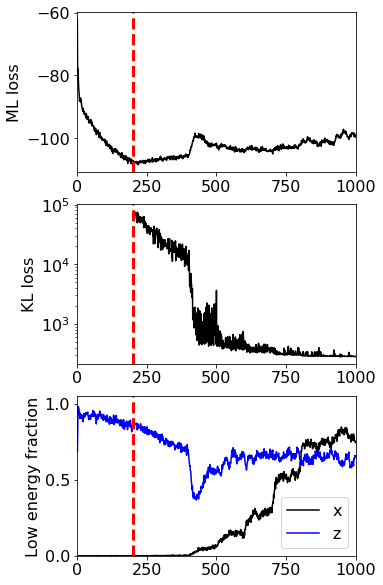

In [36]:
xcut = 80
zcut = energy_cut_z(model.dim, nstd=3)
print('zcut = ', zcut)
#hist_bg_KL_arr = np.vstack([hist_bg_KL[1] for hist_bg_KL in hists_bg_KL])
fig, axes = plot_convergence(hist_bg_ML, hist_bg_KL_combined, xcut, zcut, MLcol=1, KLcol=2);
axes[1].semilogy()
#plt.savefig(paper_dir + 'figs/particles/training_convergence.pdf', bbox_inches='tight', transparent=True)

(0, 3)

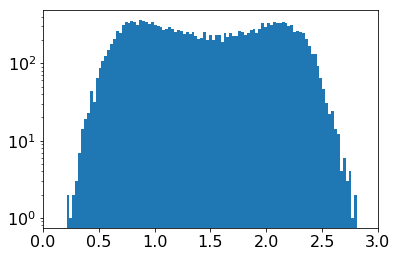

In [37]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=20000)
sample_d = model.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=True)
plt.xlim(0, 3)

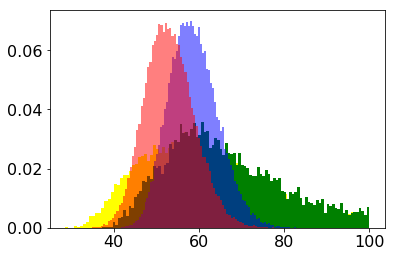

In [38]:
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d<1.5)], 100, color='yellow', density=True);
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d>1.5)], 100, color='green', density=True);
plt.hist(model.energy(traj_open_train), 100, color='blue', alpha=0.5, density=True);
plt.hist(model.energy(traj_closed_train), 100, color='red', alpha=0.5, density=True);

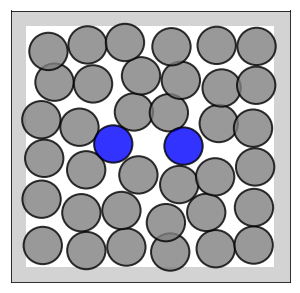

In [39]:
model.draw_config(sample_x[1], dimercolor='blue', alpha=0.8);

In [116]:
# show minimum energy path
Emin = 1e9
bestpath = None
for i in range(90):
    for j in range(90):
        path = latent_interpolation(bg, traj_closed_train[i*100], traj_open_train[j*100], nstep=9)
        E = model.energy(path).max()
        if E < Emin:
            Emin = E
            bestpath = path

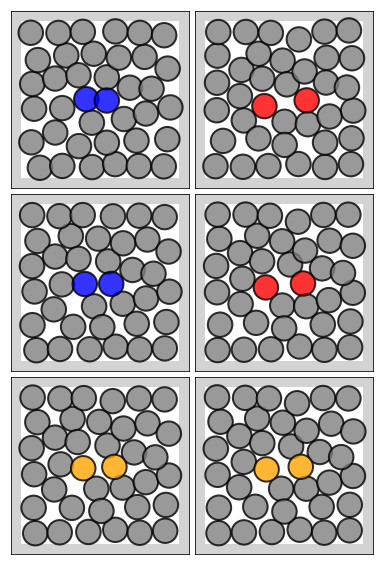

In [103]:
# Compressed version for paper
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6.5, 10))
model.draw_config(bestpath[0], axis=axes[0, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[2], axis=axes[1, 0], dimercolor='blue', alpha=0.8);
model.draw_config(bestpath[3], axis=axes[2, 0], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[4], axis=axes[2, 1], dimercolor='orange', alpha=0.8);
model.draw_config(bestpath[5], axis=axes[1, 1], dimercolor='red', alpha=0.8);
model.draw_config(bestpath[7], axis=axes[0, 1], dimercolor='red', alpha=0.8);
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.savefig(paper_dir + 'figs/particles/interpolate.pdf', bbox_inches='tight')

Free energy calculation
--------
For the paper, we run estimation at a series of different temperatures and obtain estimates of the free energy profile by averaging 10 models. Here, we only make estimates at one temperature and use a faster averaging approach that has higher statistical error: We take only one model and sample it multiple times while training it in the already converged stage. We still get slightly different estimates for different samples because of the stochasticity in SGD, but the estimates are not statistically independent and thus lead to higher uncertainties than averaging independent models.

In [44]:
from deep_boltzmann.networks.training import FlexibleTrainer
from deep_boltzmann.sampling.analysis import free_energy_bootstrap

In [41]:
s = Eschedule[-1]
flexible_trainer = FlexibleTrainer(bg, lr=s[1], batch_size=batchsize_KL, high_energy=s[2], max_energy=1e10,
                                   std=1.0, temperature=temperature, w_KL=1.0, w_ML=s[3], 
                                   w_RC=s[5], rc_func=model.dimer_distance_tf, rc_min=0.5, rc_max=2.5)

/Users/noe/anaconda/lib/python3.5/site-packages/keras/engine/topology.py:1539: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'index_layer_3/GatherV2:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'lambda_51/add:0' shape=(?, 76) dtype=float32>, <tf.Tensor 'lambda_51/add:0' shape=(?, 76) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [42]:
logws = []
sample_ds = []

In [43]:
for i in range(20):
    print('\nIter:',i)
    # train a bit
    flexible_trainer.train(X0noise, epochs=10, verbose=1)
    # sample while training:
    _, sample_x, _, energies_x, logw = bg.sample(nsample=100000)
    logws.append(logw - logw.max())
    sample_ds.append(model.dimer_distance(sample_x))


Iter: 0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 0/10 loss 356.0056 index_layer_3_loss -39.4672 lambda_51_loss 285.0871 lambda_51_loss 26.8254 
Epoch 1/10 loss 304.4827 index_layer_3_loss -50.9338 lambda_51_loss 291.2249 lambda_51_loss 26.7927 
Epoch 2/10 loss 321.7368 index_layer_3_loss -56.6500 lambda_51_loss 337.6307 lambda_51_loss 26.7356 
Epoch 3/10 loss 350.6518 index_layer_3_loss -41.6760 lambda_51_loss 289.8863 lambda_51_loss 26.9146 
Epoch 4/10 loss 187.8152 index_layer_3_loss -73.4169 lambda_51_loss 286.5809 lambda_51_loss 26.8319 
Epoch 5/10 loss 271.9084 index_layer_3_loss -56.4668 lambda_51_loss 286.3741 lambda_51_loss 26.7868 
Epoch 6/10 loss 192.0225 index_layer_3_loss -72.7738 lambda_51_loss 288.4647 lambda_51_loss 26.7427 
Epoch 7/10 loss 259.3567 index_layer_3_loss -59.0076 lambda_51_loss 286.3257 lambda_51_loss 26.8069 
Epoch 8/10 loss 207.7405 index_layer_3_loss -69.0171 lambda_51_loss 285.8438 lambda_51_loss 26.6982 
Epoc

Epoch 8/10 loss 184.5792 index_layer_3_loss -74.2305 lambda_51_loss 286.6547 lambda_51_loss 26.9077 
Epoch 9/10 loss 224.9514 index_layer_3_loss -65.8782 lambda_51_loss 285.1750 lambda_51_loss 26.9167 

Iter: 8
Epoch 0/10 loss 260.2208 index_layer_3_loss -59.2026 lambda_51_loss 286.9059 lambda_51_loss 26.9328 
Epoch 1/10 loss 340.1959 index_layer_3_loss -48.2507 lambda_51_loss 312.9757 lambda_51_loss 26.8474 
Epoch 2/10 loss 255.2430 index_layer_3_loss -60.9199 lambda_51_loss 290.7188 lambda_51_loss 26.9124 
Epoch 3/10 loss 282.9314 index_layer_3_loss -54.5293 lambda_51_loss 285.6090 lambda_51_loss 26.9969 
Epoch 4/10 loss 178.1964 index_layer_3_loss -75.1928 lambda_51_loss 284.4506 lambda_51_loss 26.9710 
Epoch 5/10 loss 242.3648 index_layer_3_loss -62.4658 lambda_51_loss 285.6506 lambda_51_loss 26.9043 
Epoch 6/10 loss 280.2350 index_layer_3_loss -54.8737 lambda_51_loss 285.6064 lambda_51_loss 26.8997 
Epoch 7/10 loss 217.6061 index_layer_3_loss -68.0209 lambda_51_loss 288.3798 lambd

Epoch 9/10 loss 228.2204 index_layer_3_loss -65.4680 lambda_51_loss 285.8944 lambda_51_loss 26.9666 

Iter: 16
Epoch 0/10 loss 240.8956 index_layer_3_loss -62.8110 lambda_51_loss 285.1706 lambda_51_loss 26.9780 
Epoch 1/10 loss 249.3796 index_layer_3_loss -61.2991 lambda_51_loss 287.0204 lambda_51_loss 26.8855 
Epoch 2/10 loss 283.4630 index_layer_3_loss -54.8238 lambda_51_loss 287.5389 lambda_51_loss 27.0043 
Epoch 3/10 loss 224.0335 index_layer_3_loss -66.5389 lambda_51_loss 287.7198 lambda_51_loss 26.9008 
Epoch 4/10 loss 218.6256 index_layer_3_loss -67.4665 lambda_51_loss 286.3221 lambda_51_loss 26.9636 
Epoch 5/10 loss 228.4991 index_layer_3_loss -65.5968 lambda_51_loss 288.7098 lambda_51_loss 26.7773 
Epoch 6/10 loss 203.3178 index_layer_3_loss -70.4140 lambda_51_loss 286.6606 lambda_51_loss 26.8727 
Epoch 7/10 loss 173.4459 index_layer_3_loss -77.4542 lambda_51_loss 291.5426 lambda_51_loss 26.9174 
Epoch 8/10 loss 217.6077 index_layer_3_loss -67.6691 lambda_51_loss 286.9636 lamb

In [45]:
bin_means = None
sample_Fs = []
for sample_d, logw in zip(sample_ds, logws):
    bin_means, sample_F = free_energy_bootstrap(sample_d, bins=100, range=(0.8, 2.2), log_weights=logw, 
                                                nbootstrap=1000, align_bins=np.arange(100))
    sample_Fs.append(sample_F)

(-18, 15)

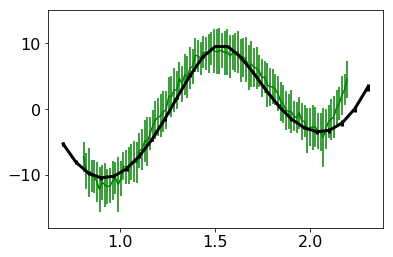

In [46]:
plt.errorbar(bin_means, np.mean(np.vstack(sample_Fs), axis=0), np.std(np.vstack(sample_Fs), axis=0), color='green')
plt.errorbar(umbrella_positions, np.mean(umbrella_free_energies, axis=0)-1, np.std(umbrella_free_energies, axis=0),
             linewidth=3, color='black')
plt.ylim(-18, 15)

Test invertibility
------

In [104]:
# test invertibility
z = np.random.randn(1000, bg.dim)
x, Jzx = bg.transform_zxJ(z)
zrec, Jxz = bg.transform_xzJ(x)

# invertible?
print(np.abs(z[:,:-6] - zrec[:,:-6]).max())

# Jacobian consistent?
print(np.abs(Jxz + Jzx).max())

1.2298439352242951e-05
4.5776367e-05


Display sampling
------

In [200]:
_, sample_x, _, energies_x, _ = bg.sample(nsample=100000)

In [187]:
traj_closed_train_ener = model.energy(traj_closed_train)
traj_open_train_ener = model.energy(traj_open_train)

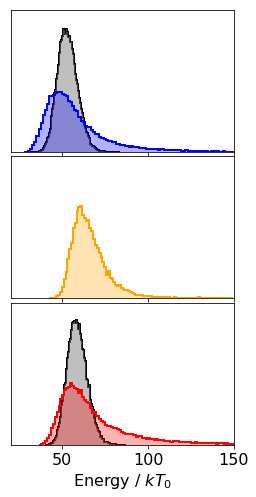

In [221]:
I_closed = np.where(model.dimer_distance(sample_x) < 1.3)[0]
energies_x_closed = energies_x[I_closed][energies_x[I_closed]<150]
I_ts = np.where(np.logical_and(model.dimer_distance(sample_x) > 1.3, model.dimer_distance(sample_x) < 1.7))[0]
energies_x_ts = energies_x[I_ts][energies_x[I_ts]<150]
I_open = np.where(model.dimer_distance(sample_x) > 1.7)[0]
energies_x_open = energies_x[I_open][energies_x[I_open]<150]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 8), sharex=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

axes[0].hist(traj_closed_train_ener, 100, color='black', histtype='step', linewidth=2, density=True);
axes[0].hist(traj_closed_train_ener, 100, color='grey', alpha=0.5, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', histtype='step', linewidth=2, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', alpha=0.3, density=True);
axes[0].set_yticks([])
axes[0].set_ylim(0, 0.08)
axes[0].set_xlim(20, 150)

axes[1].hist(energies_x_ts, 100, color='orange', histtype='step', linewidth=2, density=True);
axes[1].hist(energies_x_ts, 100, color='orange', alpha=0.3, density=True);
axes[1].set_yticks([])
axes[1].set_ylim(0, 0.08)
axes[1].set_xlim(20, 150)

axes[2].hist(traj_open_train_ener, 100, color='black', histtype='step', linewidth=2, density=True);
axes[2].hist(traj_open_train_ener, 100, color='grey', alpha=0.5, density=True);
axes[2].hist(energies_x_open, 100, color='red', histtype='step', linewidth=2, density=True);
axes[2].hist(energies_x_open, 100, color='red', alpha=0.3, density=True);
axes[2].set_yticks([])
axes[2].set_xlim(20, 150)
axes[2].set_ylim(0, 0.08)
axes[2].set_xlabel('Energy / $kT_0$')
plt.savefig(paper_dir + 'figs/particles/sampled_energies.pdf', transparent=True)

Display free energy profiles obtained from model averaging
-----

In [106]:
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite
from deep_boltzmann.util import load_obj, save_obj
from deep_boltzmann.sampling.analysis import mean_finite, std_finite
from deep_boltzmann.sampling.umbrella_sampling import UmbrellaSampling

In [107]:
# Umbrella sampling - reference
us05 = UmbrellaSampling.load('../local/particles/US_old/us_T05_F.pkl')
us10 = UmbrellaSampling.load('../local/particles/US_old/us_T10_F.pkl')
us20 = UmbrellaSampling.load('../local/particles/US_old/us_T20_F.pkl')

In [108]:
umbrella_positions = us10.umbrella_positions
pmf_us05 = us05.umbrella_free_energies()
pmf_us10 = us10.umbrella_free_energies()
pmf_us20 = us20.umbrella_free_energies()
pmf_uss = [pmf_us05, pmf_us10, pmf_us20]

In [109]:
# run training + analysis scripts to get this file 
many_sampled_distances = load_obj('../local/particles/model_averaging_old/distances_sample.pkl')

In [110]:
many_sampled_distances.keys()

dict_keys(['W05', 'W10', 'D10', 'W20', 'D05', 'temperatures', 'D20'])

In [111]:
def mean_free_energy(Ds, Ws):
    E = []
    ndrop=0
    for D, W in zip(Ds, Ws):
        # sort by descending weight
        I = np.argsort(W)[::-1]
        D_sorted = D[I][ndrop:]
        W_sorted = W[I][ndrop:]

        bins = np.linspace(0.5, 2.5, 30)
        bin_means = 0.5*(bins[:-1] + bins[1:])
        hist, _ = np.histogram(D_sorted, bins=bins, weights=np.exp(W_sorted))
        e = -np.log(hist)
        e -= np.concatenate([e[3:10],e[-10:-3]]).mean()
        E.append(e)
    E = np.array(E)
    return bin_means, mean_finite(E, axis=0, min_finite=2), std_finite(E, axis=0, min_finite=2)

In [133]:
def cut_energy(mE, cut=35.0):
    mEmin = mE[np.isfinite(mE)].min()
    mE = np.where(mE-mEmin < cut, mE, np.nan)
    return mE

In [135]:
bm05, mE05, sE05 = mean_free_energy(many_sampled_distances['D05'], many_sampled_distances['W05'])
mE05 = cut_energy(mE05, cut=35.0)
bm10, mE10, sE10 = mean_free_energy(many_sampled_distances['D10'], many_sampled_distances['W10'])
mE10 = cut_energy(mE10, cut=35.0)
bm20, mE20, sE20 = mean_free_energy(many_sampled_distances['D20'], many_sampled_distances['W20'])
mE20 = cut_energy(mE20, cut=35.0)

/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log
/Users/noe/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


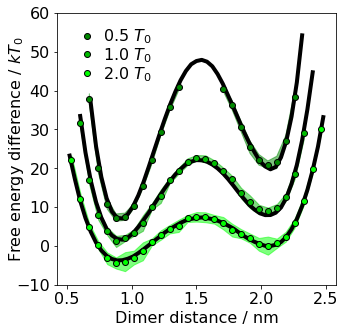

In [225]:
plt.figure(figsize=(5, 5))
#plt.fill_between(bm, mE+20-1*sE, mE+20+1*sE, color='blue', alpha=0.3)
plt.fill_between(bm05, mE05+20-1*sE05, mE05+20+1*sE05, color='#008800', alpha=0.5)
plt.plot(us05.rc_discretization, us05.rc_free_energies+6.2, linewidth=4, color='black')
plt.plot(bm05, mE05+20, color='#008800', linewidth=0, marker='.', markersize=12, markeredgewidth=1, markeredgecolor='black', label='0.5 $T_0$')

plt.fill_between(bm10, mE10+8.5-1*sE10, mE10+8.5+1*sE10, color='#00BB00', alpha=0.5)
plt.plot(us10.rc_discretization, us10.rc_free_energies+0.5, linewidth=4, color='black')
plt.plot(bm10, mE10+8.5, color='#00BB00', linewidth=0, marker='.', markersize=12, markeredgewidth=1, markeredgecolor='black', label='1.0 $T_0$')

#plt.errorbar(bm20, mE20, sE20, color='#33FF00', linewidth=0, marker='.', markersize=8, elinewidth=2, label='2.0')
plt.fill_between(bm20, mE20-1*sE20, mE20+1*sE20, color='#00FF00', alpha=0.5)
plt.plot(us20.rc_discretization, us20.rc_free_energies-5.2, linewidth=4, color='black')
plt.plot(bm20, mE20, color='#00FF00', linewidth=0, marker='.', markersize=12, markeredgewidth=1, markeredgecolor='black', label='2.0 $T_0$')


plt.legend(loc='upper left', ncol=1, frameon=False, handletextpad=0, labelspacing=0)
plt.ylim(-10, 60)
plt.xlabel('Dimer distance / nm')
plt.ylabel('Free energy difference / $kT_0$', labelpad=-10)
plt.savefig(paper_dir + 'figs/particles/free_energies_temp2.pdf', bbox_inches='tight', transparent=True)